In [1]:
pip install pandas numpy scikit-learn lightgbm matplotlib seaborn

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 5.3 MB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.5 MB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd, seaborn as sns, numpy as np

In [2]:
df = pd.read_csv("../data/raw/Energy_consumption.csv")

In [3]:
df.head()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


Identifying missing values and patterns.
Visualizing distributions of target and features with a histogram

In [4]:
df.isna().sum()

Timestamp            0
Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
DayOfWeek            0
Holiday              0
EnergyConsumption    0
dtype: int64

In [5]:
df.describe() # Tabular distribution

,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,24.982026,45.395412,1500.052488,4.581000,15.132813,77.055873
std,2.836850,8.518905,288.418873,2.865598,8.745917,8.144112
min,20.007565,30.015975,1000.512661,0.000000,0.006642,53.263278
25%,22.645070,38.297722,1247.108548,2.000000,7.628385,71.544690
50%,24.751637,45.972116,1507.967426,5.000000,15.072296,76.943696
75%,27.418174,52.420066,1740.340165,7.000000,22.884064,82.921742
max,29.998671,59.969085,1999.982252,9.000000,29.965327,99.201120


array([[<Axes: title={'center': 'Temperature'}>,
        <Axes: title={'center': 'Humidity'}>],
       [<Axes: title={'center': 'SquareFootage'}>,
        <Axes: title={'center': 'Occupancy'}>],
       [<Axes: title={'center': 'RenewableEnergy'}>,
        <Axes: title={'center': 'EnergyConsumption'}>]], dtype=object)

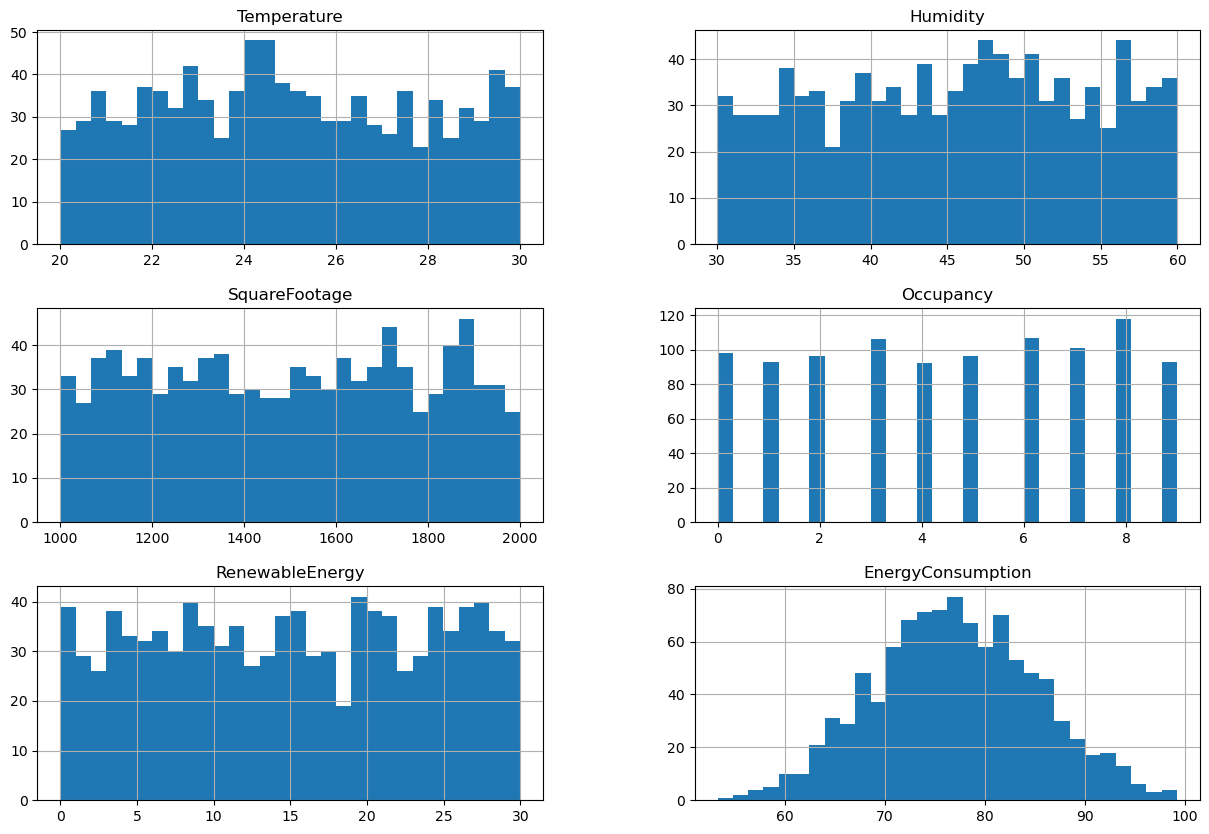

In [6]:
df.hist(bins=30, figsize=(15, 10))

<Axes: >

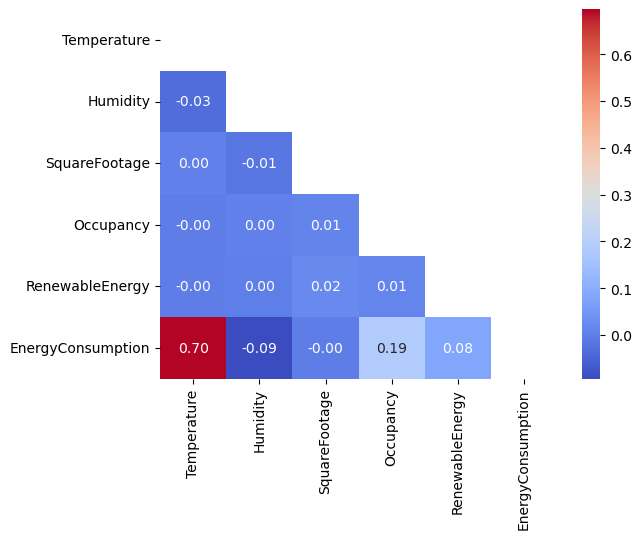

In [7]:
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")

In [8]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

df["Hour"] = df["Timestamp"].dt.hour
df["Day"] = df["Timestamp"].dt.day
df["Month"] = df["Timestamp"].dt.month


The reason for decomposing the timestamp into hour, day and month is to
factor into weather changes asscoiated with time of the day and month.

In [9]:
df = df.drop("Timestamp", axis=1)

In [10]:
df.head(3)

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month
0,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373,0,1,1
1,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855,1,1,1
2,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888,2,1,1


Changed 'Off' and 'On' to numerical represntation

In [11]:
df['HVACUsage'] = df['HVACUsage'].map({'Off': 0, 'On': 1})
df['LightingUsage'] = df['LightingUsage'].map({'Off': 0, 'On': 1})

In [12]:
df.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month
0,25.139433,43.431581,1565.693999,5,1,0,2.774699,Monday,No,75.364373,0,1,1
1,27.731651,54.225919,1411.064918,1,1,1,21.831384,Saturday,No,83.401855,1,1,1
2,28.704277,58.907658,1755.715009,2,0,0,6.764672,Sunday,No,78.270888,2,1,1
3,20.080469,50.371637,1452.316318,1,0,1,8.623447,Wednesday,No,56.519850,3,1,1
4,23.097359,51.401421,1094.130359,9,1,0,3.071969,Friday,No,70.811732,4,1,1


<Axes: >

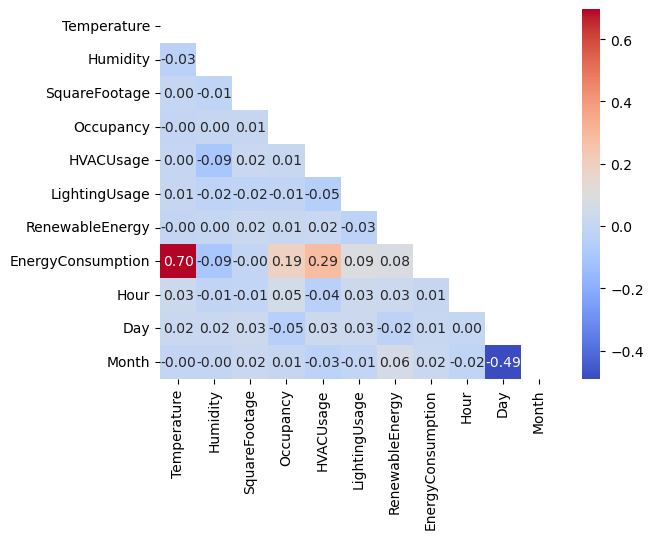

In [13]:
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")

Model Definition

Logic for the selction of LGM:
- Handles mixed feature types
- Works well on small tabular data
- nonlinear interactions
- Minimal preprocessing

In [18]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)


challenge: Produced error message


"""
ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: DayOfWeek: object, Holiday: object
"""


SOLUTION : Ordinal encoding for DayOfweek
and binary encoding for holiday

In [23]:
df["Holiday"] = df["Holiday"].map({
    "Yes": 1,
    "No": 0
})

In [25]:
df["Holiday"] = df["Holiday"].astype(int)


In [27]:
df["DayOfWeek"].unique()

array(['Monday', 'Saturday', 'Sunday', 'Wednesday', 'Friday', 'Thursday',
       'Tuesday'], dtype=object)

In [28]:
day_mapping = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6
}

df["DayOfWeek"] = df["DayOfWeek"].map(day_mapping)


In [29]:
df.head(4)

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month
0,25.139433,43.431581,1565.693999,5,1,0,2.774699,0,0,75.364373,0,1,1
1,27.731651,54.225919,1411.064918,1,1,1,21.831384,5,0,83.401855,1,1,1
2,28.704277,58.907658,1755.715009,2,0,0,6.764672,6,0,78.270888,2,1,1
3,20.080469,50.371637,1452.316318,1,0,1,8.623447,2,0,56.519850,3,1,1


In [33]:
split_index = int(len(df) * 0.8)

train_df = df.iloc[:split_index]
val_df   = df.iloc[split_index:]


In [34]:
X_train = train_df.drop("EnergyConsumption", axis=1)
y_train = train_df["EnergyConsumption"]

X_val = val_df.drop("EnergyConsumption", axis=1)
y_val = val_df["EnergyConsumption"]


In [35]:
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1102
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 12
[LightGBM] [Info] Start training from score 76.934118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMRegressor(learning_rate=0.05, n_estimators=300, random_state=42)

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

preds = model.predict(X_val)

rmse = mean_squared_error(y_val, preds)
mae  = mean_absolute_error(y_val, preds)
r2   = r2_score(y_val, preds)

In [43]:
print(f"The RMSE is {rmse:.2f}\nThe MAE is {mae:.2f}\nThe R2 is {r2:.2f}")

The RMSE is 28.43
The MAE is 4.40
The R2 is 0.54


Feature Importance

In [44]:
import pandas as pd

importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)


In [45]:
importance

,feature,importance
2,SquareFootage,1496
1,Humidity,1407
6,RenewableEnergy,1311
0,Temperature,1249
9,Hour,834
10,Day,828
3,Occupancy,633
7,DayOfWeek,424
4,HVACUsage,241
5,LightingUsage,206


Insights from Importance

- SquareFootage is the strongest driver
- followed by Enviornental Conditions such as Temperature and humidity
- Hour and Day matter more than Month

### SHAP VALUES

In [71]:
import shap
import matplotlib.pyplot as plt

In [47]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

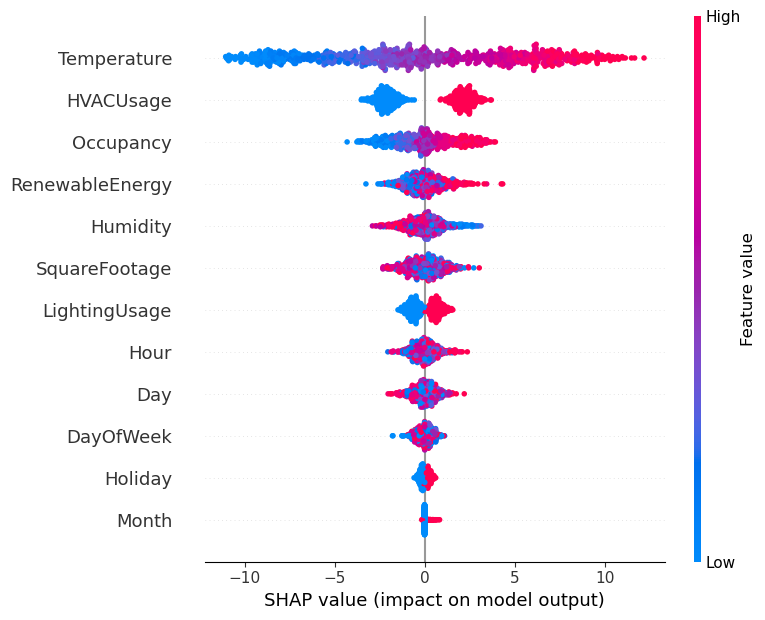

In [85]:
shap.summary_plot(shap_values, X_train)

In [87]:
shap.summary_plot(shap_values, X_train, show=False)
plt.savefig("../imgs/shap_values.png") # Vector format for high quality
plt.close()

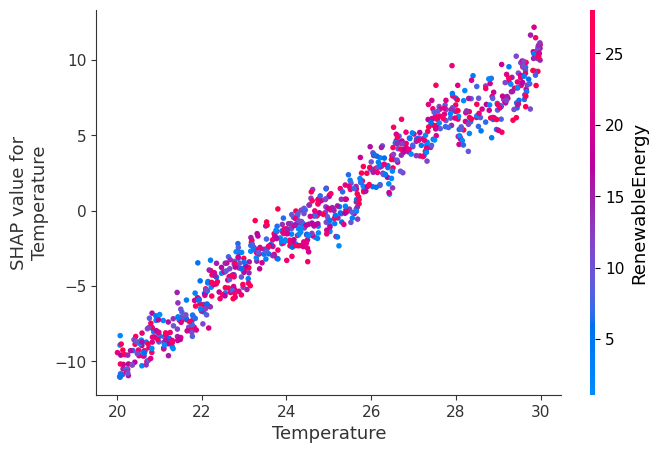

In [88]:
shap.dependence_plot("Temperature", shap_values, X_train)
plt.savefig("../imgs/shap_temperature.png") # Vector format for high quality
plt.close()

In [91]:
shap.dependence_plot("Temperature", shap_values, X_train, show=False)
plt.savefig("../imgs/shap_temperature.png") # Vector format for high quality
plt.close()

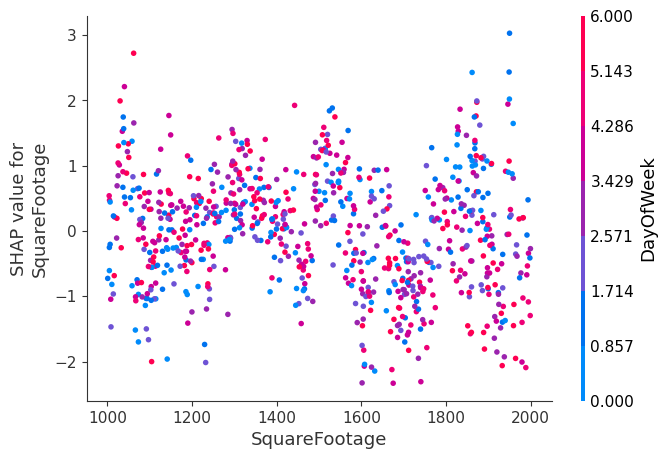

In [89]:
shap.dependence_plot("SquareFootage", shap_values, X_train)
plt.savefig("../imgs/shap_squarefootage.png") # Vector format for high quality
plt.close()

In [90]:
shap.dependence_plot("SquareFootage", shap_values, X_train, show=False)
plt.savefig("../imgs/shap_squarefootage.png") # Vector format for high quality
plt.close()

In [52]:
import shap
shap.initjs()


In [56]:
i = 4
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_train.iloc[i]
)


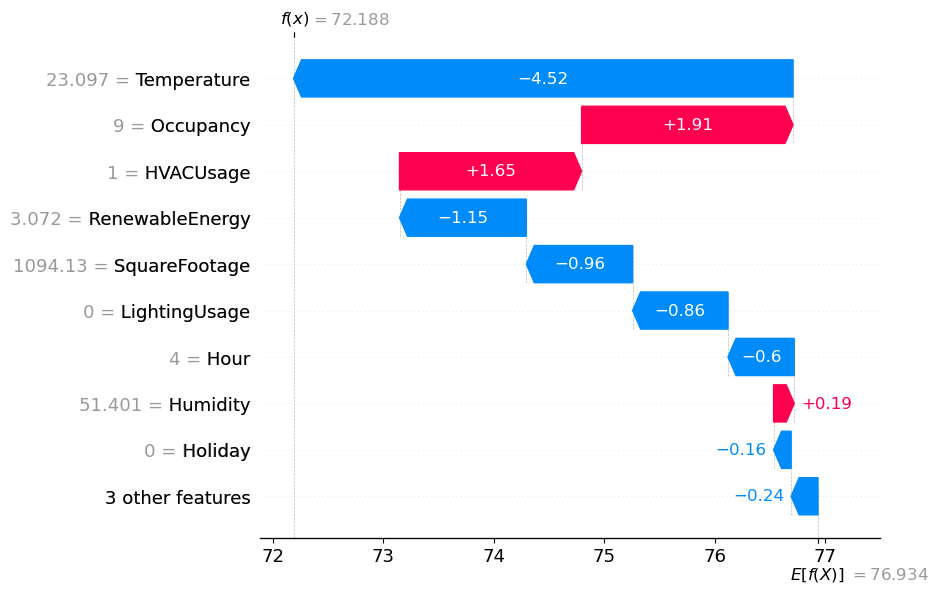

In [57]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[i],
        base_values=explainer.expected_value,
        data=X_train.iloc[i],
        feature_names=X_train.columns
    )
)


### QuESTIONS

Why does SHAP elevate Temperature above SquareFootage 
when the importance table clearly ranks SquareFootage first?”


If I start from the average energy consumption, 
how much does each feature push the prediction up or down for each row

### Structural features (defines the baseline)

- SquareFootage

- Occupancy

### Dynamic drivers (brings deviation)

- Temperature

- Humidity

- Hour

- HVACUsage

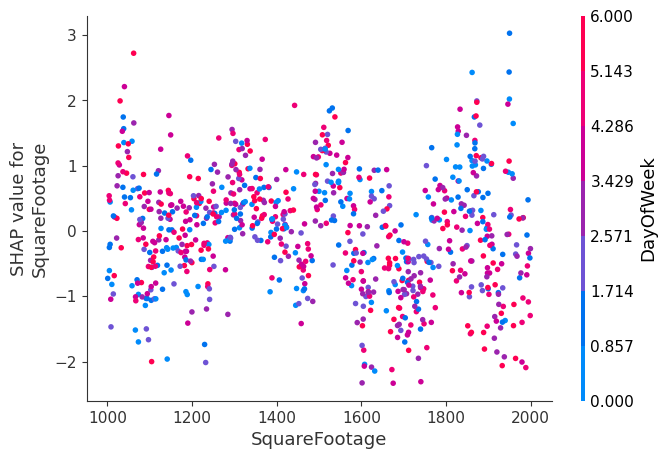

In [64]:
shap.dependence_plot("SquareFootage", shap_values, X_train)


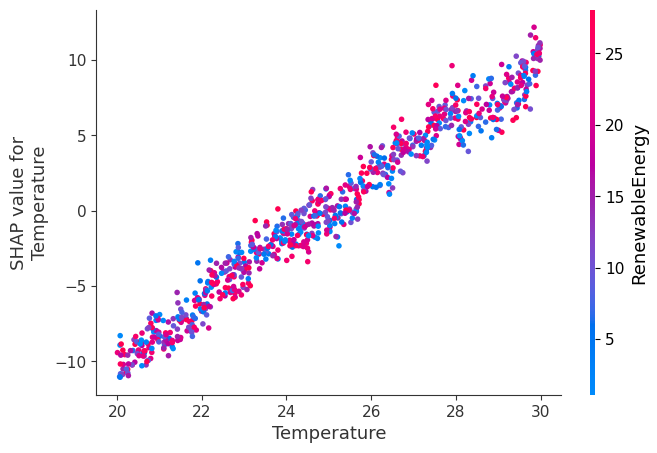

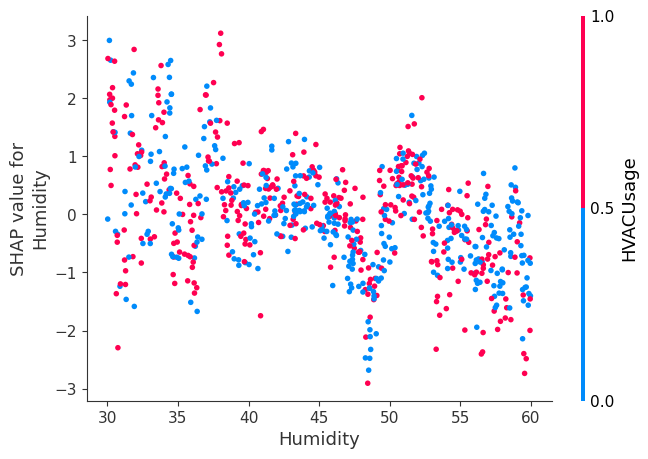

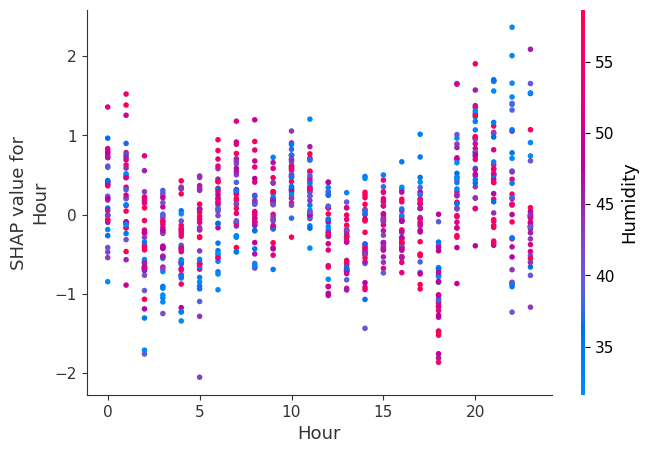

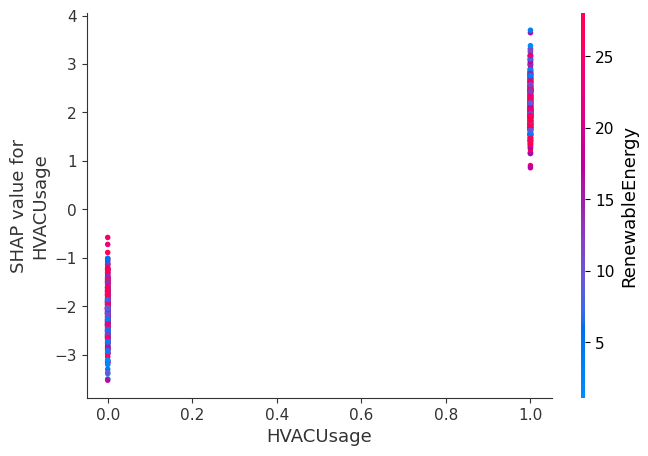

In [67]:
shap.dependence_plot("Temperature", shap_values, X_train)
shap.dependence_plot("Humidity", shap_values, X_train)
shap.dependence_plot("Hour", shap_values, X_train)
shap.dependence_plot("HVACUsage", shap_values, X_train)

## Interaction Plot

In [68]:
# Compute the 3D interaction values
interaction_values = explainer.shap_interaction_values(X_train)


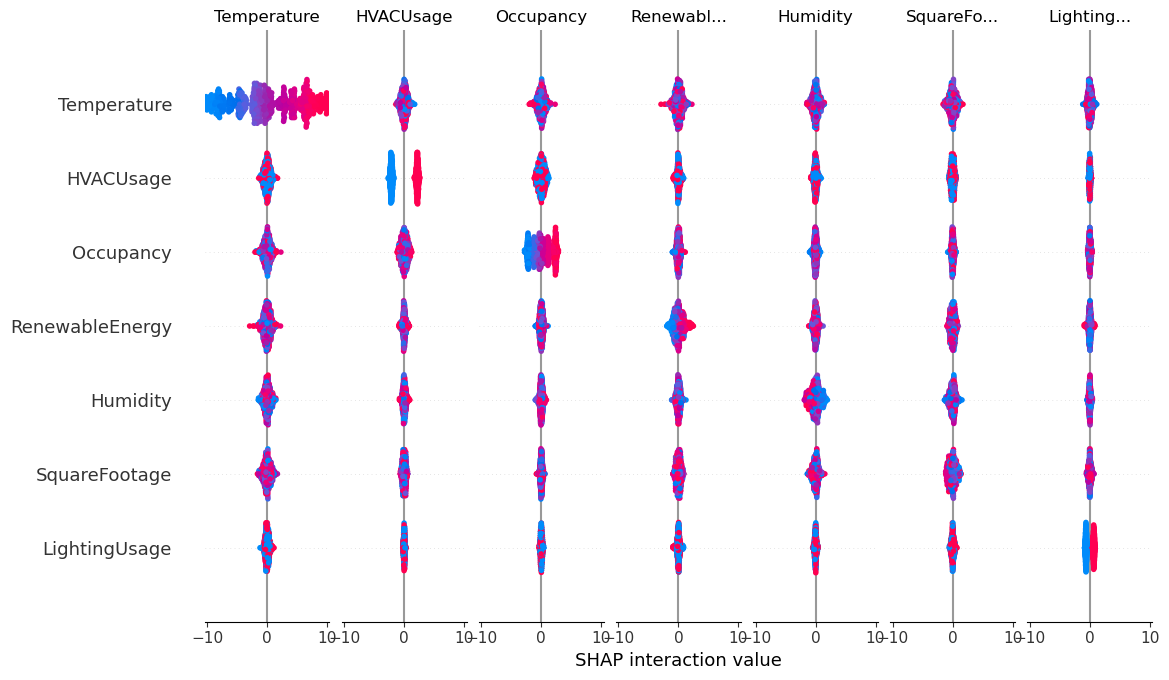

In [80]:
# Visualizes a matrix of interactions between all features
shap.summary_plot(interaction_values, X_train)

Strong interactions would show wider, more dispersed violin plots.

Here, most interactions are weak (narrow distributions near zero), 

but Temperature and potentially LightingUsage show more complex behavior patterns 
that might be worth investigating further in your model.

In [77]:
 # Close the figure to free up memory
plt.close()

In [84]:
# Save the interaction matrix
shap.summary_plot(interaction_values, X_train, show=False)
plt.savefig("../imgs/all_interactions.png") # Vector format for high quality
plt.close()


# Save the model

In [82]:
import joblib
joblib.dump(model, "../models/energy_consumption_lgbm.pkl")


['../models/energy_consumption_lgbm.pkl']